# Regresiones

Aquí vamos a hacer muchas regresiones para ver qué combinación de ingeniería de variables y método de regresión da mejores resultados.

El primer paso es establecer una _línea base_ para comparar. Para esto vamos a utilizar una regresión de [Random Forest](https://en.wikipedia.org/wiki/Random_forest) sobre los datos preprocesados diréctamente, sin más. Lo único extra que vamos a hacer es escalar las variables.

Hay varias razones para usar Random Forest como baseline, primero es sabido que es un buen método para evitar el _overfitting_ y segundo y más importante en nuestro caso, nos da una estimación de la importancia relativa de las variables, esto puede resultar importante para informar nuestras desiciones más adelante.

En general, una regresión tiene un conjunto de _hiperparámetros_ que deben ajustarse para obtener un modelo específico. Este ajuste se hace buscando soluciones en el espacio de hiperparámetros, para evitar ajustar nuestro modelo demasiado (aumentar el sesgo), vamos a usar _cross validation_.

Primero vamos a ver cuáles son los hiperparámetros que queremos ajustar:

In [17]:
# leemos los datos
import pandas as pd
df_train = pd.read_csv("data/train_preprocesado.csv")
#por alguna razón quedaron dos Na en BsmtCond, así los quitamos pero en realidad hay que regresar a ver qué pasó
df_train.dropna(inplace=True)
# creamos dataframes para las variables y el objetivo
Y = df_train['SalePrice']
X = df_train.drop(['SalePrice','Id'], axis=1)

In [3]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
print('Parámetros por defecto:\n')
pprint(rf.get_params())

Parámetros por defecto:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


- n_estimators = número de árboles en el bosque
- max_features = máximo número de variables a considerar en cada _split_
- max_depth = profundidad máxima para cada árbol
- min_samples_split = numero mínimo de datos en un nodo antes de un _split_
- min_samples_leaf = número mínimo de datos en un nodo
- bootstrap = método para muestrear (con o sin reemplazo)

Si lo piensa uno, son un montón de parámetros con un montón de valores posibles, entonces tenemos que encontrar alguna forma eficiente de buscar (en el espacio de hiperparámetros). Ahora lo que vamos a hacer es una búsqueda en dos etapas. primero vamos a definir una _malla_ grande de valores y vamos a buscar a azar dentro de esa malla, eso nos va a reducir el espacio de búsqueda, luego vamos a usar ese espacio reducido para utilizar un método más sofisticado (pero más costoso computacionalmente) de búsqueda. 

In [45]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
# Lista ed valores para el número de estimadores
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# máximo número de variables a considerar en cada _split_
max_features = ['auto', 'sqrt']
# profundidad máxima para cada árbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# numero mínimo de datos en un nodo antes de un _split_
min_samples_split = [2, 5, 10]
# número mínimo de datos en un nodo
min_samples_leaf = [1, 2, 4]
# método para muestrear (con o sin reemplazo)
#bootstrap = [True, False]
# Malla aleatoria
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
pprint(random_grid)

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


Hay exáctamente $2 * 12 * 2 * 3 * 3 * 10 = 4320$ combinaciones de variables en nuestra malla. Por eso no las vamos a probar todas, vamos a buscar aleatoriamente. 

Evidentemente, la búsqueda para encontrar un buen conjunto de hiperparámetros necesita una métrica para medir el desempeño. En sklearn, cada regresor provee metricas de evaluación, el problema es que esa evaluación se hace sobre la muestra completa, es decir, sobre todos los datos que el modelo _ya vió_. Esto representa un problema porque con facilidad vamos a caer en overfitting, es decir, aumentar la _varianza_ del modelo: su sensibilidad a los datos con los que se entrenó. Modelos con alta varianza, tienden a tener errores grandes cuando se les utiliza con datos nuevos.

Métodos basados en _bootstraping_ como los Random Forests, proveen una forma natural de eliminar este problema: estimar el error utilizando lo que se llama la muestra _Out of Bag_ (OOB). Este tipo de métodos de ensamble utiliza sólo una porción de los datos para entrenar cada uno de los regresores individuales, de esta forma, al final hay un conjunto de observaciones que no fueron empleadas para entrenar _ningún_ regresor individual, esta muestra (OOB) se puede utilizar para estimar el error sin caer en overfitting. Entonces, vamos a hacer nuestra búsquerda usando el `oob_score`.


In [46]:
# Creamos un modelo vacío
rf = RandomForestRegressor(oob_score=True, bootstrap=True)
# Búsqueda aleatoria usando 3-fold CV, 
# Busca sobre 100 iteraciones 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Ajusta sobre los datos
rf_random.fit(X, Y)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.0min finished


{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

Ahora vamos a ver si la búsqueda aleatoria nos da un mejor modelo que el modelo base (con parámetros por default). 

In [52]:
base_model = RandomForestRegressor(n_estimators = 100, random_state = 42, oob_score=True)
base_model.fit(X, Y)
print('El score para el modelo base es: {:0.4f}'.format(base_model.oob_score_))
print('El score para el mejor modelo de la búsqueda aleatoria: {:0.4f}'.format(rf_random.best_estimator_.oob_score_))
print('La mejora fue de {:0.2f}%'.format(100 * (rf_random.best_estimator_.oob_score_ - base_model.oob_score_) / base_model.oob_score_))

El score para el modelo base es: 0.8744
El score para el mejor modelo de la búsqueda aleatoria: 0.8759
La mejora fue de 0.17%


Marginalmente pero mejoramos!

Ahora vamos a ver si refinando la búsqueda, a partir de los parámetros que ya encontramos, podemos mejorar un poco más.

In [57]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [15, 20, 25],
    'max_features': [230, 240, 251],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 3, 5],
    'n_estimators': [800, 800, 1000]
}
# Create a based model
rf = RandomForestRegressor(oob_score=True, bootstrap=True)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X, Y)
grid_search.best_params_

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed: 22.4min finished


{'max_depth': 20,
 'max_features': 230,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 800}

Teóricamente esta debería ser una refinación de lo que ya obtuvimos. Probémoslo

In [58]:
print('El score para el modelo refinado es: {:0.4f}'.format(grid_search.best_estimator_.oob_score_))
print('El score para el mejor modelo de la búsqueda aleatoria: {:0.4f}'.format(rf_random.best_estimator_.oob_score_))
print('La mejora fue de {:0.2f}%'.format(100 * (grid_search.best_estimator_.oob_score_ - rf_random.best_estimator_.oob_score_) / rf_random.best_estimator_.oob_score_))

El score para el modelo refinado es: 0.8762
El score para el mejor modelo de la búsqueda aleatoria: 0.8759
La mejora fue de 0.03%


Bueno, marginalmente pero seguimos mejorando...

Una ventaja de los Random Forests es que nos  pueden dar una medida de la importancia relativa de los parámtetros, grafiquemos estas para el mejor modelo que tenemos

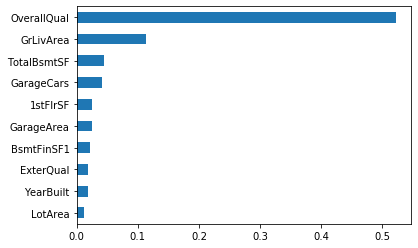

In [63]:
%matplotlib inline
feat_importances = pd.Series(grid_search.best_estimator_.feature_importances_, index=X.columns)
feat_importances.nlargest(10).sort_values().plot(kind='barh')

Quizá no tan sorprendentemente la calidad general es la variables más importante.

## Baseline

Ahora sí tenemos ya nuestro modelo, entonces sometámos los resultados a Kaggle para ver cómo le va. Este es el modelo más simple y el resultado en realidad sólo va a servir como base para comparar los refinamientos que hagamos más adelante.

Para hacer la predicción sobre los datos de prueba, vamos a usar el csv con los datos prerpocesados igual que la muestra de entrenamiento y después exportar los resultados en el formato necesario.

In [95]:
test_df = pd.read_csv("data/test_preprocesado.csv")
#test_df.drop(['Unnamed: 0.1'], axis=1, inplace=True)
#X_test = test_df.drop(['Id'], axis=1)
result = grid_search.best_estimator_.predict(X_test)

In [99]:
result_df = pd.DataFrame(result)
result_df.columns = ['SalePrice']
result_df = result_df.join(test_df['Id'])
#result_df.to_csv("data/result_base.csv", index=False)

In [102]:
result_df['SalePrice'] = np.exp(result_df['SalePrice'])
result_df.to_csv("data/result_base.csv", index=False)

,SalePrice,Id
0,119187.545888,1461
1,147335.347805,1462
2,169191.564164,1463
3,174843.510971,1464
4,193777.908958,1465
...,...,...
1454,75231.458875,2915
1455,77768.304761,2916
1456,157359.329947,2917
1457,107807.366896,2918


In [103]:
result_df.to_csv("data/result_base.csv", index=False)

Como podríamos querer usar nuestro modelo más adelante, lo vamos a guardar

In [100]:
from joblib import dump, load
dump(grid_search.best_estimator_, 'data/models/baseline_RF.joblib')

# Para usarlo después:
# model = load('data/models/baseline_RF.joblib')

['data/models/baseline_RF.joblib']